<a href="https://colab.research.google.com/github/Uma-kanagarajan/Gender-Prediction/blob/main/name_gender_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary libraries

In [1]:
#import all the necessary libraries

import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

### Load the dataset

In [4]:
# load and preview the data

names_df = pd.read_csv('name_gender.csv')
names_df.head()

,name,gender
0,Aaban&&,M
1,Aabha*,F
2,Aabid,M
3,Aabriella,F
4,Aada_,F


In [5]:
print("The Shape of the dataset: ", names_df.shape)
print("The Columns of the dataset are ", names_df.columns)
print("Any missing values in the dataset ", names_df.isnull().sum())
print("Unique value counts for the gender variable :", names_df['gender'].value_counts())

The Shape of the dataset:  (95025, 2)
The Columns of the dataset are  Index(['name', 'gender'], dtype='object')
Any missing values in the dataset  name      0
gender    0
dtype: int64
Unique value counts for the gender variable : F    60304
M    34721
Name: gender, dtype: int64


### Preprocess the dataset

In [6]:
#define a function to preprocess the data.

''' 
This function takes names as input and converts it into an array using below steps.
1. Removes non-alphabetical characters and spaces from the given input name.
2. Then tokenize each characters of the name into a vector and converts it into an integer
3. Given name length gets changed to a fixed length of 20 with the help of post padded sequence

Input Parameter: name(string/list of strings)

Function output: name array

'''

def preprocess_name(names_df):
  names_df['name'] = names_df['name'].str.replace('[^a-zA-Z]', '') #remove unncessary characters
  names = names_df['name'].values 
  tokenizer = Tokenizer(num_words=None, oov_token=oov_tok, char_level=True) # Character splitting in tokenizer
  tokenizer.fit_on_texts(names)   #Train the corpus
  sequences = tokenizer.texts_to_sequences(names)  #convert character to integer
  name_length = 20
  input_sequences = pad_sequences(sequences, maxlen=name_length, padding='post')  #padding
  #input_array = np.asarray(input_sequences) 

  return input_sequences

### Model definition

In [7]:
# function for model definition

''' 

This function defines a model with sequential API with the layers such as
Embedding, LSTM, Dropout, Dense and a final dense output layer.
Optimizer: Adam
Loss: Binary crossentropy.

Input Parameter: Input dimension, output dimension and input length for embedding layer

Function output: Model

'''

def lstm_model(num_alphabets, embedding_dim, name_length):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=name_length),
        #Bidirectional(LSTM(units=32, recurrent_dropout=0.2, dropout=0.2)),
        Bidirectional(LSTM(units=32)),
        Dropout(0.2),
        Dense(units=32, activation='relu'),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.01),
                  metrics=['accuracy'])

    return model

### Model Building

In [8]:
#create oov token value
oov_tok = "<OOV>"

#Step 1: Preprocess the input features(names)
X = preprocess_name(names_df)

#Step 2: Get labels using Label Encoder
le = preprocessing.LabelEncoder()
names_df['gender'] = le.fit_transform(names_df['gender'])
y = np.asarray(names_df['gender'].values.tolist())

#Step 3: Split Training and Test Data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0
                                                    )

#Step 4: Instantiate the model
model = lstm_model(num_alphabets=28, embedding_dim=28, name_length=20)
    

In [9]:
#Step 5 : Train the model
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=128,
                    epochs=200,
                    validation_data=(X_test, y_test),
                    callbacks=[callbacks])


#Step 6: Save the model
model.save('gender_prediction.h5')


Epoch 1/200
594/594 [==============================] - 52s 71ms/step - loss: 0.4069 - accuracy: 0.8159 - val_loss: 0.3472 - val_accuracy: 0.8493
Epoch 2/200
594/594 [==============================] - 26s 44ms/step - loss: 0.3401 - accuracy: 0.8554 - val_loss: 0.3145 - val_accuracy: 0.8672
Epoch 3/200
594/594 [==============================] - 27s 46ms/step - loss: 0.3127 - accuracy: 0.8688 - val_loss: 0.2984 - val_accuracy: 0.8739
Epoch 4/200
594/594 [==============================] - 27s 45ms/step - loss: 0.2968 - accuracy: 0.8767 - val_loss: 0.2900 - val_accuracy: 0.8791
Epoch 5/200
594/594 [==============================] - 30s 50ms/step - loss: 0.2843 - accuracy: 0.8822 - val_loss: 0.2779 - val_accuracy: 0.8840
Epoch 6/200
594/594 [==============================] - 24s 41ms/step - loss: 0.2755 - accuracy: 0.8865 - val_loss: 0.2729 - val_accuracy: 0.8851
Epoch 7/200
594/594 [==============================] - 31s 51ms/step - loss: 0.2677 - accuracy: 0.8882 - val_loss: 0.2707 - val_ac

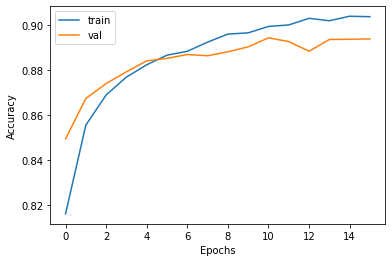

In [10]:
#Step 7: Visualize the model accuracies

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Model Evaluation

In [11]:
#define a function to evaluate the test data.

"""
This function evaluates the model for the test data and shows the result in a datafram.

Input Parameter: Model, X_test, y_test

Function output: Evaluation Dataframe

"""

def evaluate_model(model, X_test, y_test):

    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    return display_df

# Evaluate model on test set and add results to dataframe
results = evaluate_model(model, X_test, y_test)

# Set index to 'Baseline'
results.index = ['Baseline']

# Display results
results.head()

594/594 [==============================] - 13s 22ms/step - loss: 0.2637 - accuracy: 0.8942


,loss,accuracy
Baseline,0.263721,0.894186


### Model Prediction

In [12]:
y_pred = model.predict(X_test)

In [13]:
name = ['Mark', 'Rosie', 'Andrew', 'Antony', 'Pooja', 'Xin Yang', 'Fei', 'Albert', 'Chun Hua', 'rita']

# Convert to dataframe
pred_df = pd.DataFrame({'name': name})

# Preprocess the given names
name_array = preprocess_name(pred_df)

# Prediction
predict_x = model.predict(name_array)
gender_list = []
for i in predict_x:
  if i >0.5:
    gender_list.append('Male')
  else:
    gender_list.append('Female')


# Format the output
pred_df['name'] = name
pred_df.rename(columns={'name': 'Name'}, inplace=True)
pred_df['Gender'] = gender_list
pred_df['Probability'] = predict_x.round(2)
pred_df.drop_duplicates(inplace=True)

pred_df

,Name,Gender,Probability
0,Mark,Male,0.83
1,Rosie,Male,0.67
2,Andrew,Male,0.96
3,Antony,Female,0.09
4,Pooja,Female,0.02
5,Xin Yang,Male,0.83
6,Fei,Male,0.83
7,Albert,Male,0.95
8,Chun Hua,Female,0.04
9,rita,Female,0.08
